In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

code_dir=Path.cwd()
project_dir=code_dir.parent
cat_dir=project_dir.parent/"cat12"
input_dir=project_dir/"input"
output_dir=project_dir/"output/abannotate"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True)

In [2]:
bootstrap_pls_df_schaefer100 = pd.read_csv(project_dir/"output/pls/pls_ukb_bootstrap_schaefer100_df.csv", header=None)

# PLS

In [5]:
cell_label_dict_styled = {'Ex1':"Excitatory neurons subtype 1",
 'Ex2':"Excitatory neurons subtype 2",
 'Ex3':"Excitatory neurons subtype 3",
 'Ex4':"Excitatory neurons subtype 4",
 'Ex5':"Excitatory neurons subtype 5",
 'Ex6':"Excitatory neurons subtype 6",
 'Ex7':"Excitatory neurons subtype 7",
 'Ex8':"Excitatory neurons subtype 8",
 'In1':"Inhibitory neurons subtype 1",
 'In2':"Inhibitory neurons subtype 2",
 'In3':"Inhibitory neurons subtype 3",
 'In4':"Inhibitory neurons subtype 4",
 'In5':"Inhibitory neurons subtype 5",
 'In6':"Inhibitory neurons subtype 6",
 'In7':"Inhibitory neurons subtype 7",
 'In8':"Inhibitory neurons subtype 8",
 'Astro':"Astrocytes",
 'Endo':"Endothelium",
 'Micro':"Microglia",
 'Oligo':"Oligodendrocytes"}

In [6]:
from statsmodels.stats.multitest import multipletests as multicomp

cell = pd.read_csv(output_dir/"GCEA_CellTypes.csv")
cell = cell[(cell["cLabel"]!="Dev-replicating") & (cell["cLabel"]!="Dev-quiescent") & (cell["cLabel"]!="Adult-OtherNeuron") & (cell["cLabel"]!="Adult-OPC")].reset_index()

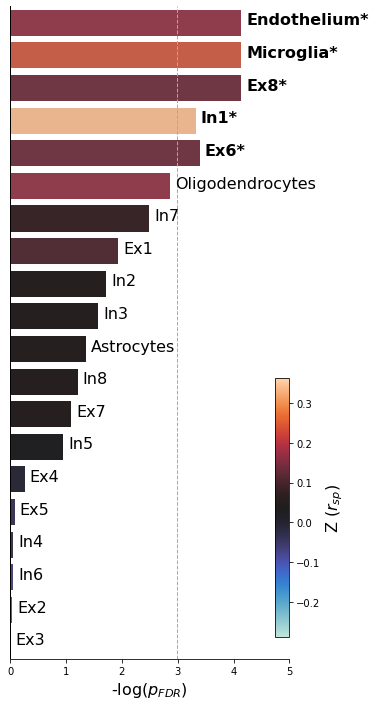

In [8]:
cell[["cLabel","cGenes","cScorePheno","pValPermCorr"]].to_csv(output_dir/"virtual_histology_statistics.csv")

In [ ]:
from enigmatoolbox.datasets import fetch_ahba

# Fetch gene expression data

genes = fetch_ahba("https://raw.githubusercontent.com/saratheriver/enigma-extra/master/ahba/allgenes_stable_r0.2_schaefer_100.csv")
genes = genes.iloc[:100,:]

# Obtain region labels

reglabels = genes['label']

In [ ]:
for i, row in cell.iterrows():
    gcea_celltypes_parc = genes.loc[:,genes.columns.isin(row.cGenes.split(", "))]
    gcea_celltypes_parc.to_csv(output_dir/f'GCEA_cell_genes_{row.cLabel}.csv')


In [ ]:
cell_label_dict = dict(zip(cell.cLabel, cell.cLabel.str.split("-",expand=True)[1]))

cell_label_dict

{'Adult-Endo': 'Endo',
 'Adult-Micro': 'Micro',
 'Adult-Ex8': 'Ex8',
 'Adult-Ex6': 'Ex6',
 'Adult-In1': 'In1',
 'Adult-Oligo': 'Oligo',
 'Adult-In7': 'In7',
 'Adult-Ex1': 'Ex1',
 'Adult-In3': 'In3',
 'Adult-In2': 'In2',
 'Adult-Astro': 'Astro',
 'Adult-In8': 'In8',
 'Adult-Ex7': 'Ex7',
 'Adult-In5': 'In5',
 'Adult-Ex4': 'Ex4',
 'Adult-Ex5': 'Ex5',
 'Adult-In4': 'In4',
 'Adult-In6': 'In6',
 'Adult-Ex2': 'Ex2',
 'Adult-Ex3': 'Ex3'}

In [11]:
endo_df = pd.read_csv(output_dir/f'GCEA_cell_genes_Adult-Endo.csv', index_col=0)
micro_df = pd.read_csv(output_dir/f'GCEA_cell_genes_Adult-Micro.csv', index_col=0)
ex8_df = pd.read_csv(output_dir/f'GCEA_cell_genes_Adult-Ex8.csv', index_col=0)
ex6_df = pd.read_csv(output_dir/f'GCEA_cell_genes_Adult-Ex6.csv', index_col=0)
in1_df = pd.read_csv(output_dir/f'GCEA_cell_genes_Adult-In1.csv', index_col=0)

In [ ]:
from enigmatoolbox.datasets import load_fc
_, schaefer_labels, _, _ = load_fc(parcellation=f'schaefer_100')

all_cells_df = pd.concat([endo_df, micro_df, ex8_df, ex6_df, in1_df], axis=1)
all_cells_df.index = list(schaefer_labels) + ["celltype"]
all_cells_df = all_cells_df.loc[["celltype"] + list(schaefer_labels)].T


In [36]:
endo_df.loc["celltype",:] = "endo"
micro_df.loc["celltype",:] = "micro"
ex8_df.loc["celltype",:] = "ex8"
ex6_df.loc["celltype",:] = "ex6"
in1_df.loc["celltype",:] = "in1"


In [37]:
genes_df = pd.concat([endo_df, micro_df, ex8_df, ex6_df, in1_df], axis=1)

In [42]:
from scipy.stats import spearmanr
genewise_correlation = genes_df.iloc[:100,:].apply(lambda x: spearmanr(x,bootstrap_pls_df_schaefer100, nan_policy="omit")[0])
genewise_correlation_df = pd.DataFrame(genewise_correlation)
genewise_correlation_df["celltype"] = genes_df.T["celltype"]
genewise_correlation_df.columns = ["r","celltype"]

In [72]:
endo_top_5_df = genewise_correlation_df[genewise_correlation_df.celltype=="endo"].sort_values(by="r", ascending=False).iloc[:5,:]
micro_top_5_df = genewise_correlation_df[genewise_correlation_df.celltype=="micro"].sort_values(by="r", ascending=False).iloc[:5,:]
ex8_top_5_df = genewise_correlation_df[genewise_correlation_df.celltype=="ex8"].sort_values(by="r", ascending=False).iloc[:5,:]
ex6_top_5_df = genewise_correlation_df[genewise_correlation_df.celltype=="ex6"].sort_values(by="r", ascending=False).iloc[:5,:]
in1_top_5_df = genewise_correlation_df[genewise_correlation_df.celltype=="in1"].sort_values(by="r", ascending=False).iloc[:5,:]

In [73]:
endo_top_5 = endo_top_5_df.index
micro_top_5 = micro_top_5_df.index
ex8_top_5 = ex8_top_5_df.index
ex6_top_5 = ex6_top_5_df.index
in1_top_5 = in1_top_5_df.index

In [78]:
top_5_df = pd.concat([endo_top_5_df, micro_top_5_df, ex8_top_5_df, ex6_top_5_df, in1_top_5_df], axis=0)

tuples = list(zip(top_5_df.index, top_5_df["celltype"]))
hierarchical_index = pd.MultiIndex.from_tuples(tuples, names=["gene","celltype"])

tuples = list(zip(genes_df.T.index, genes_df.T["celltype"]))
hierarchical_index_genes_df = pd.MultiIndex.from_tuples(tuples, names=["gene","celltype"])
genes_df_reindexed = genes_df.T.set_index(hierarchical_index_genes_df)

top_5_df.index = hierarchical_index
top_5_df = top_5_df.join(genes_df_reindexed.drop(columns="celltype"))
top_5_genes_to_plot = top_5_df.drop(["r","celltype"], axis=1)

In [80]:
r_dict = dict()
for gene in top_5_genes_to_plot.index:
    r = top_5_df.loc[gene,"r"]
    if type(r) == pd.core.series.Series:
        r = r[0]
    r_dict[gene] = r 

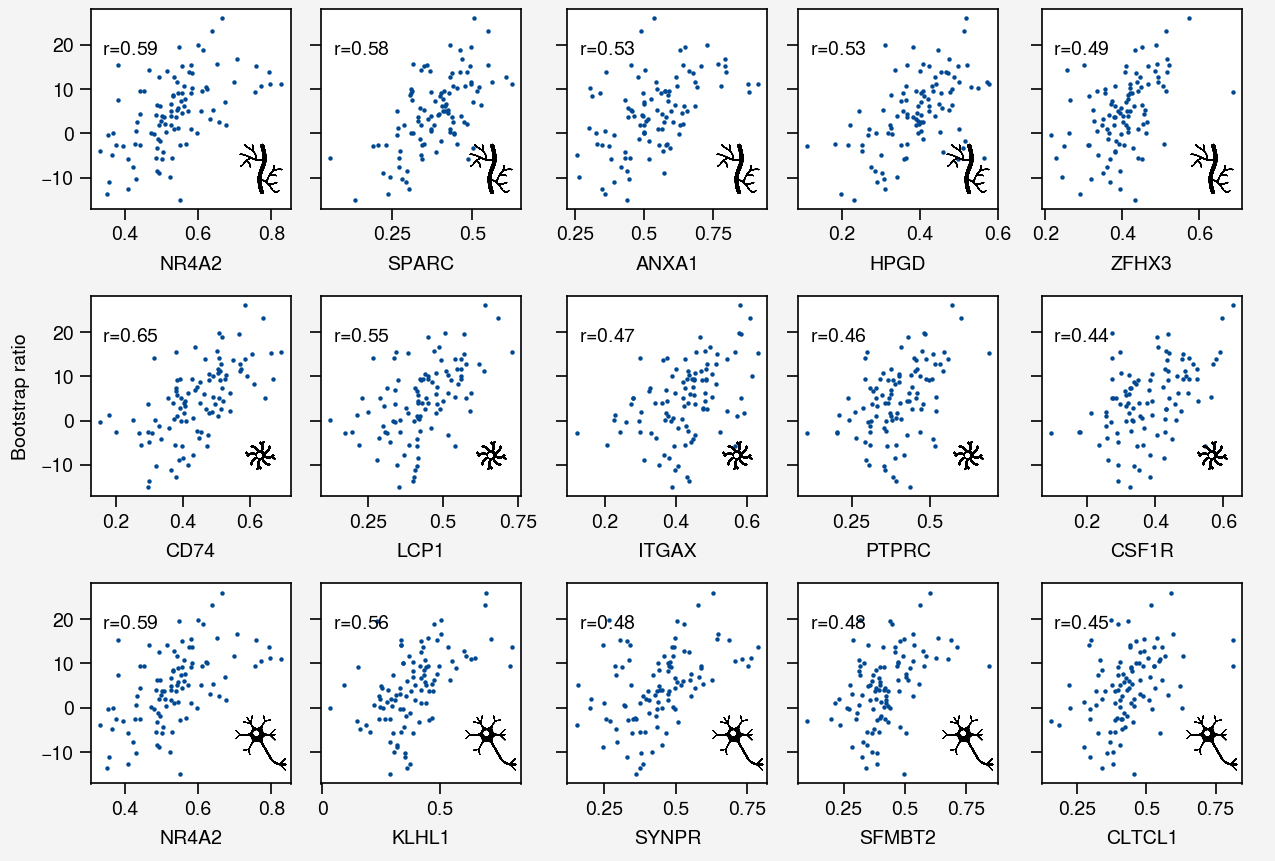

In [ ]:
import proplot as pplt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import numpy as np

pplt.rc.fontsize = 7
fig = pplt.figure(refwidth=1, refheight=1, spany=True, spanx=False, sharey=True, sharex=False)
axs = fig.subplots(nrows=3, ncols=5)

for idx,ax in enumerate(axs):

    ax.scatter(top_5_genes_to_plot.iloc[idx], bootstrap_pls_df_schaefer100, s=1, color="#004992")
    
    ax.format(xlabel=top_5_genes_to_plot.index[idx][0])

    zoom=.035
    if idx <5:
        pngpath= output_dir/"vasculature.png"
    elif idx >=5 and idx <10:
        zoom=0.02
        pngpath= output_dir/"microglia.png"
    elif idx >=10 and idx <15:
        pngpath= output_dir/"neuron1.png"
    elif idx >=15 and idx <20:
        pngpath= output_dir/"neuron1.png"
    elif idx >=20:
        pngpath= output_dir/"neuron1.png"

    def getImage(path):
        return OffsetImage(plt.imread(pngpath, format="png"), zoom=zoom)
    ab = AnnotationBbox(getImage(pngpath), xy=(0.85,0.2), boxcoords="axes fraction", frameon=False, annotation_clip=False) #
    ax.add_artist(ab)

    offsetbox = TextArea(f"$r$={r_dict[top_5_genes_to_plot.index[idx]]:.2f}",textprops=dict(size=7))
    ab = AnnotationBbox(offsetbox, xy,
                    xybox=(0.2,0.8),
                    boxcoords="axes fraction",
                    annotation_clip=False,
                    frameon=False)
    ax.add_artist(ab)

axs.format(
    ylabel='Bootstrap ratio',
    grid=False,
    ytickminor=False,
    xtickminor=False,
)
plt.savefig(output_dir/'top5_genes_correlations.png', dpi=300)
